# A single pendulum with damping

In [322]:
'''
Generate a single pendulum data from ODEs
'''
%matplotlib inline

import numpy as np
from scipy.integrate import odeint
from math import *
import matplotlib.pyplot as plt


def deriv(y, t, L):
    """Return the first derivatives of y = theta, omega."""
    theta, omega = y

    theta_dot = omega
    omega_dot = -(g/L)*np.sin(theta) - damping_c*theta_dot
    
    return theta_dot, omega_dot

def calc_E(y):
    """Return the total energy of the system."""
    if isinstance(y, np.ndarray):
        theta, theta_dot = y.T
        V = M*g*L*(1-np.cos(theta))
        T = 0.5*M*(L*theta_dot)**2
    elif isinstance(y, torch.Tensor):
        theta, theta_dot = y.T
        V = M*g*L*(1-torch.cos(theta))
        T = 0.5*M*(L*theta_dot)**2
    else:
        raise TypeError("type of y is :{}. It should be numpy.ndarray or torch.Tensor".format(type(y)))
    
    return (V, T, T + V)

# Constants
g = 9.81    # The gravitational acceleration (m.s-2).
damping_c = 0.02    # Damping coefficient (kg.s-1)

# Variables
# Pendulum rod lengths (m), bob masses (kg).
L, M = 1, 1
print("Length and Mass of a string: {}, {}".format(L, M))
theta0 = np.random.uniform(-np.pi/6, np.pi/6)
omega0 = np.random.uniform(-10,10)
print("Initial theta(degree) and omega: {:.6f}({:.6f}), {:.6f}".format(theta0, 180.*theta0/np.pi, omega0))


# Maximum time, time point spacings and the time grid (all in s).
tmax, dt = 300, 0.0001
t = np.arange(0, tmax+dt, dt)
# Initial conditions: theta, omega
y0 = np.array([theta0, omega0])

# Do the numerical integration of the equations of motion
y = odeint(deriv, y0, t, args=(L,))    # (theta, omega)

# Calculate energy
V, T, E = calc_E(y)

Length and Mass of a string: 1, 1
Initial theta(degree) and omega: -0.331595(-18.999020), -5.242453


In [323]:
np.max(y, axis=0), np.min(y, axis=0)

(array([1.99334746, 5.28971091]), array([-2.02908194, -5.24245269]))

Text(0, 0.5, 'Velocity (rad/s)')

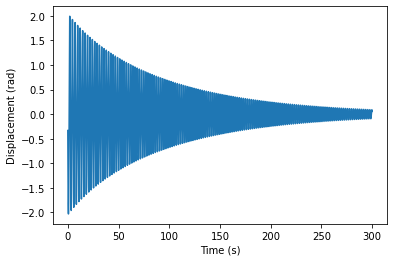

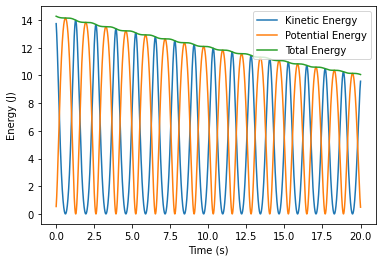

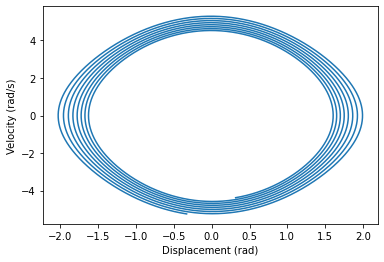

In [324]:
t_range = 200000

plt.figure(0)
# plt.plot(t[:t_range], y[:t_range,0])
plt.plot(t[:], y[:,0])
plt.xlabel('Time (s)')
plt.ylabel('Displacement (rad)')

plt.figure(1)
plt.plot(t[:t_range], T[:t_range], label='Kinetic Energy')
plt.plot(t[:t_range], V[:t_range], label='Potential Energy')
plt.plot(t[:t_range], E[:t_range], label='Total Energy')
plt.legend(loc='upper right')
plt.xlabel('Time (s)')
plt.ylabel('Energy (J)')

plt.figure(2)
plt.plot(y[:t_range,0], y[:t_range,1])
plt.xlabel('Displacement (rad)')
plt.ylabel('Velocity (rad/s)')

In [11]:
'''
Data preprocessing for NN
'''
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data.dataloader as dataloader

device = torch.device("cuda:0")


sampling_step = 100    # sample a row for every the step.
sampling_ind = np.arange(0, t.shape[0]-1, sampling_step)
scaler = 0.1
scaled_y = np.array(y)
scaled_y[:,1] = scaled_y[:,1]*scaler

input_output_y = np.concatenate((scaled_y[:-1], scaled_y[1:]), axis=1)    # [[input, output]]
X = torch.tensor(np.concatenate((input_output_y[sampling_ind], )), dtype=torch.float32, device=device)

num_samples = X.shape[0]
X_tr, X_val, X_te = X[:int(num_samples*0.6)], X[int(num_samples*0.6):int(num_samples*0.6)], X[int(num_samples*0.6):]

train_loader = dataloader.DataLoader(X_tr, batch_size=32, shuffle=True)
print("data size: {}/{}/{}".format(len(train_loader.dataset), len(X_val), len(X_te)))

data size: 18000/0/12000


In [281]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.net = nn.Sequential(nn.Linear(2,32),
                                 nn.ReLU(),
                                 nn.Linear(32,2))
        
    def forward(self, x):
        return self.net(x)


# lr = 0.00005
lr = 0.0001
model = Net().to(device)
total_params = sum(p.numel() for p in model.parameters())
print("total parameters: {}".format(total_params))

loss_fn = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=lr)
# optimizer = optim.Adadelta(model.parameters(), lr=0.05)

epochs = 20
log_interval = 200
# Training
for epoch in range(1, epochs+1):
    model.train()
    for batch_idx, data in enumerate(train_loader):
        data, target = data[:,:2], data[:,2:]    # check
        optimizer.zero_grad()
        output = model(data)
        _, _, curr_E = calc_E(data)
        _, _, pred_E = calc_E(output)
        _, _, target_E = calc_E(target)
                
#         loss = loss_fn(output, target)    # No rules

#         loss = (loss_fn(output, target) + loss_fn(pred_E, target_E)) + \
#                torch.mean(F.relu(pred_E - curr_E))
        alpha = 1.0
        loss = (1-alpha)*(loss_fn(output, target) + loss_fn(pred_E, target_E)) + \
               alpha*torch.mean(F.relu(pred_E - curr_E))
        
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

# Test
model.eval()
test_loss = 0
with torch.no_grad():
    target = X_te[:,2:]
    output = model(X_te[:,:2])
    test_loss = loss_fn(output, target).item()  # sum up batch loss

print('\nTest set: Average loss: {:.8f}\n'.format(test_loss))

total parameters: 162
Train Epoch: 1 [0/18000 (0%)]	Loss: 0.026735
Train Epoch: 1 [6400/18000 (36%)]	Loss: 0.002395
Train Epoch: 1 [12800/18000 (71%)]	Loss: 0.000049
Train Epoch: 2 [0/18000 (0%)]	Loss: 0.000131
Train Epoch: 2 [6400/18000 (36%)]	Loss: 0.000067
Train Epoch: 2 [12800/18000 (71%)]	Loss: 0.000000
Train Epoch: 3 [0/18000 (0%)]	Loss: 0.000029
Train Epoch: 3 [6400/18000 (36%)]	Loss: 0.000000
Train Epoch: 3 [12800/18000 (71%)]	Loss: 0.000000
Train Epoch: 4 [0/18000 (0%)]	Loss: 0.000000
Train Epoch: 4 [6400/18000 (36%)]	Loss: 0.000000
Train Epoch: 4 [12800/18000 (71%)]	Loss: 0.000000
Train Epoch: 5 [0/18000 (0%)]	Loss: 0.000000
Train Epoch: 5 [6400/18000 (36%)]	Loss: 0.000000
Train Epoch: 5 [12800/18000 (71%)]	Loss: 0.000000
Train Epoch: 6 [0/18000 (0%)]	Loss: 0.000000
Train Epoch: 6 [6400/18000 (36%)]	Loss: 0.000000
Train Epoch: 6 [12800/18000 (71%)]	Loss: 0.000000
Train Epoch: 7 [0/18000 (0%)]	Loss: 0.000000
Train Epoch: 7 [6400/18000 (36%)]	Loss: 0.000000
Train Epoch: 7 [1280

In [223]:
# maes_no_rule = [0.002626, 0.004409, 0.005109, 0.004921, 0.006121]
# maes_with_rule = [0.000377, 0.000521, 0.001033, 0.000306, 0.001213]    # Adadelta

maes_no_rule = [0.000010, 0.000082, 0.000040, 0.000066, 0.000012]
maes_with_rule = [0.000079, 0.000079, 0.000086, 0.000097, 0.000052]    # Adam

np.mean(maes_no_rule), np.std(maes_no_rule)
# np.mean(maes_with_rule), np.std(maes_with_rule)

(4.2000000000000004e-05, 2.864960732715197e-05)


Test set: Average loss on theta: 0.044713
Test set: Average loss on omega: 0.033929

0.03932111710309982


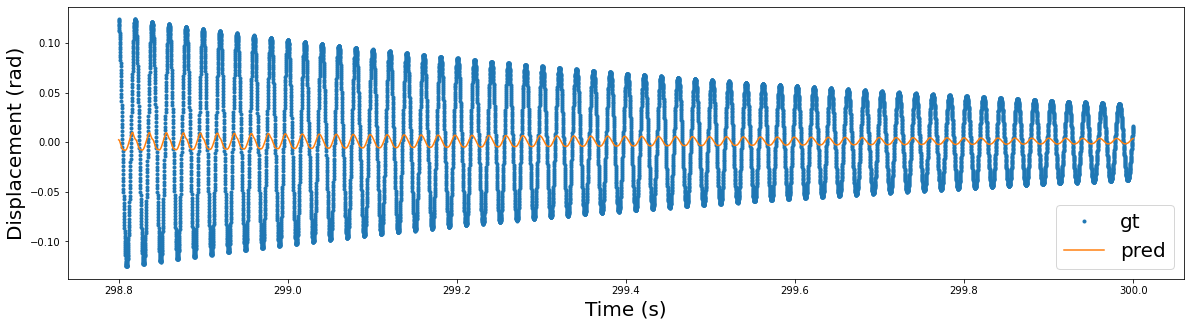

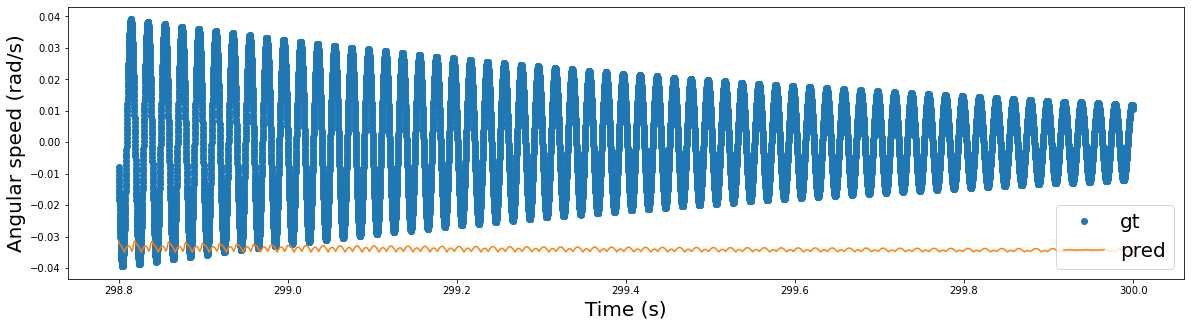

In [282]:
# Perturbations
delta = 0.0
theta_delta = np.pi/6*np.random.uniform(-delta, delta, size=(X_te.shape[0], 1))
omega_delta = 1*np.random.uniform(-delta, delta, size=(X_te.shape[0], 1))
pert_array = torch.tensor(np.concatenate((theta_delta, omega_delta), axis=1), dtype=torch.float32).to(device)

model.eval()
test_loss = 0
with torch.no_grad():
    target = X_te[:,2:]
#     output = model(X_te[:,:2])
    output = model(X_te[:,:2] + pert_array)
    test_loss1 = loss_fn(output[:,0], target[:,0]).item()  # sum up batch loss
    test_loss2 = loss_fn(output[:,1], target[:,1]).item()  # sum up batch loss

print('\nTest set: Average loss on theta: {:.6f}'.format(test_loss1))
print('Test set: Average loss on omega: {:.6f}\n'.format(test_loss2))
print((test_loss1+test_loss2)/2)

plt.figure(0, figsize=(20,5))
plt.plot(t[-X_te.shape[0]:], target[:,0].cpu(), '.', label='gt')
plt.plot(t[-X_te.shape[0]:], output[:,0].cpu(), label='pred')
plt.xlabel('Time (s)', fontsize=20)
plt.ylabel('Displacement (rad)', fontsize=20)
plt.legend(loc='lower right', fontsize=20)

plt.figure(1, figsize=(20,5))
plt.plot(t[-X_te.shape[0]:], target[:,1].cpu(), 'o', label='gt')
plt.plot(t[-X_te.shape[0]:], output[:,1].cpu(), label='pred')
plt.xlabel('Time (s)', fontsize=20)
plt.ylabel('Angular speed (rad/s)', fontsize=20)
plt.legend(loc='lower right', fontsize=20)

In [13]:
def verification(in_X, out_X, threshold=0.1):
    '''
    return the ratio of qualified samples.
    '''
    _, _, curr_E = calc_E(in_X)
    _, _, next_E = calc_E(out_X)

    return 1.0*torch.sum(next_E-curr_E <= threshold) / curr_E.shape[0]

In [284]:
# result_with_constraint = {1.0: {'mae': maes_with_constraint, 'rate': rates_with_constraint}}
result_with_constraint[alpha] = {'mae': maes_with_constraint, 'rate': rates_with_constraint}
# result_with_constraint[1.0] = {'mae': maes_with_constraint, 'rate': rates_with_constraint}
# result_with_constraint[0.8] = {'mae': maes_with_constraint, 'rate': rates_with_constraint}
# result_with_constraint[0.6] = {'mae': maes_with_constraint, 'rate': rates_with_constraint}
# result_with_constraint[0.4] = {'mae': maes_with_constraint, 'rate': rates_with_constraint}
# result_with_constraint[0.2] = {'mae': maes_with_constraint, 'rate': rates_with_constraint}
# result_with_constraint[0.0] = {'mae': maes_with_constraint, 'rate': rates_with_constraint}
# result_with_constraint = {0.0: {'mae': maes_with_constraint, 'rate': rates_with_constraint}}

Text(0, 0.5, 'Rate (%)')

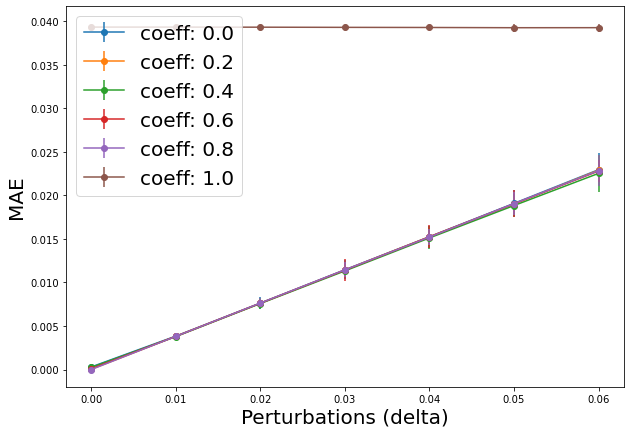

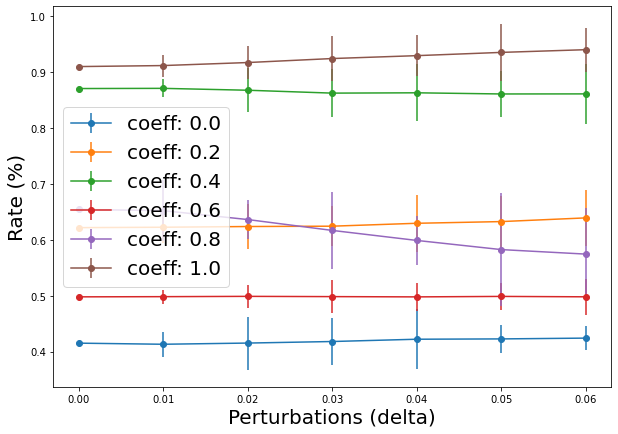

In [288]:


plt.figure(0, figsize=(10,7))
for coeff, val in result_with_constraint.items():
    maes_dict = val['mae']
    
    maes = np.array([np.mean(val) for key, val in maes_dict.items()])
    mae_stds = np.array([np.std(val) for key, val in maes_dict.items()])
    
    plt.errorbar(deltas, maes, yerr=mae_stds*20, marker='o', label='coeff: {}'.format(coeff))
    
plt.legend(loc='upper left', fontsize=20)
plt.xlabel('Perturbations (delta)', fontsize=20)
plt.ylabel('MAE', fontsize=20)
# plt.ylim([0.0, 0.03])


plt.figure(1, figsize=(10,7))
for coeff, val in result_with_constraint.items():
    rates_dict = val['rate']
    
    rates = np.array([np.mean(val) for key, val in rates_dict.items()])
    rate_stds = np.array([np.std(val) for key, val in rates_dict.items()])
    
    plt.errorbar(deltas, rates, yerr=rate_stds*20, marker='o', label='coeff: {}'.format(coeff))
    
plt.legend(loc='center left', fontsize=20)
plt.xlabel('Perturbations (delta)', fontsize=20)
plt.ylabel('Rate (%)', fontsize=20)

In [283]:
# Perturbations
maes_with_constraint = {}
rates_with_constraint = {}
deltas = [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06]
threshold = 0.0 #1e-5
for delta in deltas:
    mae_temp = []
    rate_temp = []
    for _ in range(10):
        theta_delta = np.pi/6*np.random.uniform(-delta, delta, size=(X_te.shape[0], 1))
        omega_delta = 1*np.random.uniform(-delta, delta, size=(X_te.shape[0], 1))
        pert_array = torch.tensor(np.concatenate((theta_delta, omega_delta), axis=1), dtype=torch.float32).to(device)

        model.eval()
        test_loss = 0
        with torch.no_grad():
            target = X_te[:,2:]
            X_te_pert = X_te[:,:2] + pert_array
            output = model(X_te_pert)
            test_loss = loss_fn(output, target).item()  # sum up batch loss
            rate = verification(X_te_pert[:,:2].cpu(), output.cpu(), threshold=threshold)
            
        mae_temp.append(test_loss)
        rate_temp.append(rate)
        
    maes_with_constraint[delta] = mae_temp
    rates_with_constraint[delta] = rate_temp

    print('Test set (delta: {}): Average loss: {:.6f}({:.6f}) Average rate: {:.4f}({:.4f}) (threshold:{})'
          .format(delta, np.mean(mae_temp), np.std(mae_temp), np.mean(rate_temp), np.std(rate_temp),threshold))

Test set (delta: 0.0): Average loss: 0.039321(0.000000) Average rate: 0.9103(0.0000) (threshold:0.0)
Test set (delta: 0.01): Average loss: 0.039321(0.000003) Average rate: 0.9121(0.0010) (threshold:0.0)
Test set (delta: 0.02): Average loss: 0.039310(0.000006) Average rate: 0.9175(0.0015) (threshold:0.0)
Test set (delta: 0.03): Average loss: 0.039291(0.000016) Average rate: 0.9246(0.0020) (threshold:0.0)
Test set (delta: 0.04): Average loss: 0.039276(0.000010) Average rate: 0.9298(0.0019) (threshold:0.0)
Test set (delta: 0.05): Average loss: 0.039249(0.000024) Average rate: 0.9356(0.0026) (threshold:0.0)
Test set (delta: 0.06): Average loss: 0.039254(0.000023) Average rate: 0.9405(0.0020) (threshold:0.0)


In [231]:
maes_wo_constraint = {}
rates_wo_constraint = {}
deltas = [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06]
threshold = 1e-5
for delta in deltas:
    mae_temp = []
    rate_temp = []
    for _ in range(10):
        theta_delta = np.pi/6*np.random.uniform(-delta, delta, size=(X_te.shape[0], 1))
        omega_delta = 1*np.random.uniform(-delta, delta, size=(X_te.shape[0], 1))
        pert_array = torch.tensor(np.concatenate((theta_delta, omega_delta), axis=1), dtype=torch.float32).to(device)

        model.eval()
        test_loss = 0
        with torch.no_grad():
            target = X_te[:,2:]
            X_te_pert = X_te[:,:2] + pert_array
            output = model(X_te_pert)
            test_loss = loss_fn(output, target).item()  # sum up batch loss
            rate = verification(X_te_pert[:,:2].cpu(), output.cpu(), threshold=threshold)
            
        mae_temp.append(test_loss)
        rate_temp.append(rate)
        
    maes_wo_constraint[delta] = mae_temp
    rates_wo_constraint[delta] = rate_temp

    print('Test set (delta: {}): Average loss: {:.6f}({:.6f}) Average rate: {:.4f}({:.4f}) (threshold:{})'
          .format(delta, np.mean(mae_temp), np.std(mae_temp), np.mean(rate_temp), np.std(rate_temp), threshold))

Test set (delta: 0.0): Average loss: 0.000010(0.000000) Average rate: 0.9255(0.0000) (threshold:1e-05)
Test set (delta: 0.01): Average loss: 0.003813(0.000013) Average rate: 0.9173(0.0010) (threshold:1e-05)
Test set (delta: 0.02): Average loss: 0.007629(0.000020) Average rate: 0.8923(0.0019) (threshold:1e-05)
Test set (delta: 0.03): Average loss: 0.011420(0.000040) Average rate: 0.8550(0.0015) (threshold:1e-05)
Test set (delta: 0.04): Average loss: 0.015247(0.000063) Average rate: 0.8167(0.0017) (threshold:1e-05)
Test set (delta: 0.05): Average loss: 0.019065(0.000037) Average rate: 0.7836(0.0031) (threshold:1e-05)
Test set (delta: 0.06): Average loss: 0.022892(0.000087) Average rate: 0.7549(0.0038) (threshold:1e-05)


In [ ]:
maes_with = np.array([np.mean(val) for key, val in maes_with_constraint.items()])
mae_stds_with = np.array([np.std(val) for key, val in maes_with_constraint.items()])
maes_wo = np.array([np.mean(val) for key, val in maes_wo_constraint.items()])
mae_stds_wo = np.array([np.std(val) for key, val in maes_wo_constraint.items()])
plt.figure(0, figsize=(10,7))
plt.errorbar(deltas, maes_with, yerr=mae_stds_with*5, marker='o', label='w/ rule')
plt.errorbar(deltas, maes_wo, yerr=mae_stds_wo*5, marker='o', label='w/o rule')
plt.legend(loc='upper left', fontsize=20)
plt.xlabel('Perturbations (delta)', fontsize=20)
plt.ylabel('MAE', fontsize=20)

rates_with = np.array([np.mean(val) for key, val in rates_with_constraint.items()])
rate_stds_with = np.array([np.std(val) for key, val in rates_with_constraint.items()])
rates_wo = np.array([np.mean(val) for key, val in rates_wo_constraint.items()])
rate_stds_wo = np.array([np.std(val) for key, val in rates_wo_constraint.items()])
plt.figure(1, figsize=(10,7))
plt.errorbar(deltas, rates_with, yerr=rate_stds_with*5, marker='o', label='w/ rule')
plt.errorbar(deltas, rates_wo, yerr=rate_stds_wo*5, marker='o', label='w/o rule')
plt.legend(loc='center left', fontsize=20)
plt.xlabel('Perturbations (delta)', fontsize=20)
plt.ylabel('Rate (%)', fontsize=20)


Test set: Average loss on theta: 0.088250
Test set: Average loss on omega: 0.100029

0.09413934126496315


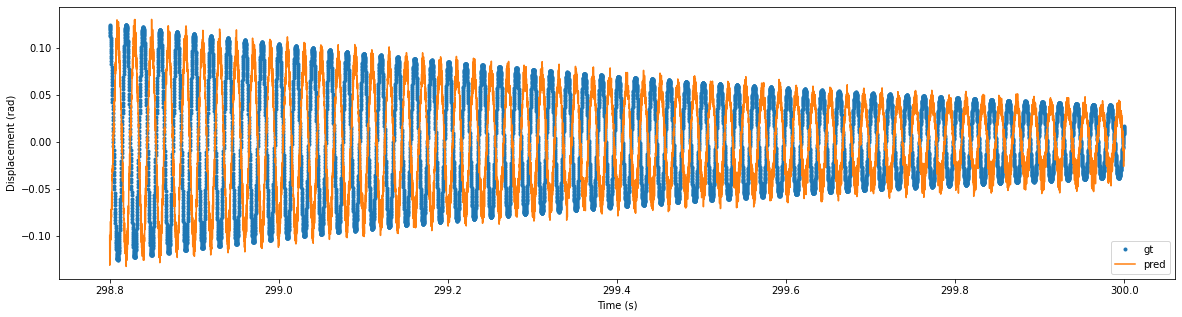

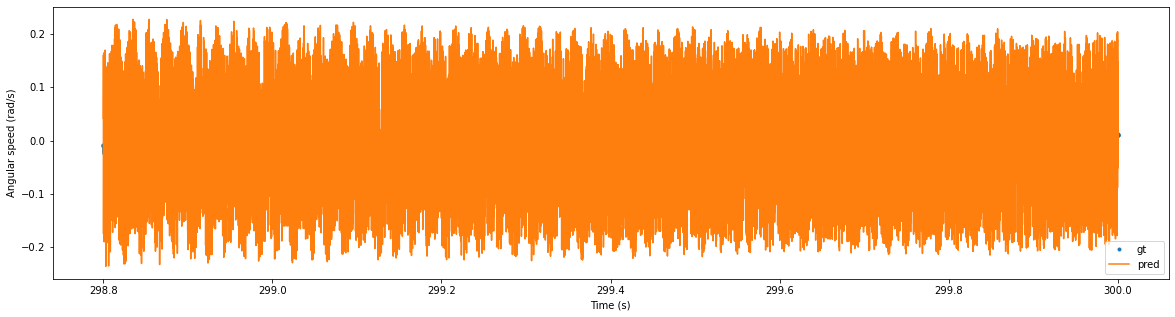

In [83]:
# Perturbations
delta = 0.02
theta_delta = np.pi/6*np.random.uniform(-delta, delta, size=(X_te.shape[0], 1))
omega_delta = 10*np.random.uniform(-delta, delta, size=(X_te.shape[0], 1))
pert_array = torch.tensor(np.concatenate((theta_delta, omega_delta), axis=1), dtype=torch.float32).to(device)

model.eval()
test_loss = 0
with torch.no_grad():
    target = X_te[:,2:]
#     output = model(X_te[:,:2])
    output = model(X_te[:,:2] + pert_array)
    test_loss1 = loss_fn(output[:,0], target[:,0]).item()  # sum up batch loss
    test_loss2 = loss_fn(output[:,1], target[:,1]).item()  # sum up batch loss

print('\nTest set: Average loss on theta: {:.6f}'.format(test_loss1))
print('Test set: Average loss on omega: {:.6f}\n'.format(test_loss2))
print((test_loss1+test_loss2)/2)

plt.figure(0, figsize=(20,5))
plt.plot(t[-X_te.shape[0]:], target[:,0].cpu(), '.', label='gt')
plt.plot(t[-X_te.shape[0]:], output[:,0].cpu(), label='pred')
plt.xlabel('Time (s)')
plt.ylabel('Displacement (rad)')
plt.legend(loc='lower right')

plt.figure(1, figsize=(20,5))
plt.plot(t[-X_te.shape[0]:], target[:,1].cpu(), '.', label='gt')
plt.plot(t[-X_te.shape[0]:], output[:,1].cpu(), label='pred')
plt.xlabel('Time (s)')
plt.ylabel('Angular speed (rad/s)')
plt.legend(loc='lower right')

Text(0, 0.5, 'Velocity (rad/s)')

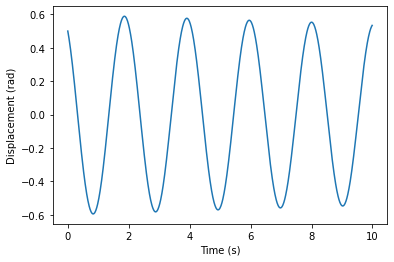

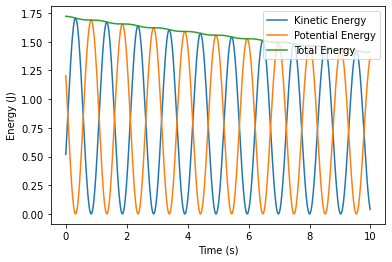

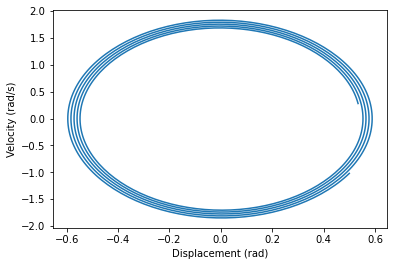

In [86]:
t_range = 1000

plt.figure(0)
plt.plot(t[sampling_ind][:t_range], y[sampling_ind,0][:t_range])
plt.xlabel('Time (s)')
plt.ylabel('Displacement (rad)')

plt.figure(1)
plt.plot(t[sampling_ind][:t_range], T[sampling_ind][:t_range], label='Kinetic Energy')
plt.plot(t[sampling_ind][:t_range], V[sampling_ind][:t_range], label='Potential Energy')
plt.plot(t[sampling_ind][:t_range], E[sampling_ind][:t_range], label='Total Energy')
plt.legend(loc='upper right')
plt.xlabel('Time (s)')
plt.ylabel('Energy (J)')

plt.figure(2)
plt.plot(y[sampling_ind,0][:t_range], y[sampling_ind,1][:t_range])
plt.xlabel('Displacement (rad)')
plt.ylabel('Velocity (rad/s)')

## Double pendulum without damping

In [332]:
%matplotlib inline

import sys
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from matplotlib.patches import Circle



def deriv(y, t, L1, L2, M1, M2):
    """Return the first derivatives of y = theta1, z1, theta2, z2."""
    theta1, z1, theta2, z2 = y

    c, s = np.cos(theta1-theta2), np.sin(theta1-theta2)

    theta1dot = z1
    z1dot = (M2*g*np.sin(theta2)*c - M2*s*(L1*z1**2*c + L2*z2**2) -
             (M1+M2)*g*np.sin(theta1)) / L1 / (M1 + M2*s**2)
    theta2dot = z2
    z2dot = ((M1+M2)*(L1*z1**2*s - g*np.sin(theta2) + g*np.sin(theta1)*c) + 
             M2*L2*z2**2*s*c) / L2 / (M1 + M2*s**2)
    return theta1dot, z1dot, theta2dot, z2dot

def calc_E(y):
    """Return the total energy of the system."""

    th1, th1d, th2, th2d = y.T
    V = -(M1+M2)*L1*g*np.cos(th1) - M2*L2*g*np.cos(th2) + (M1+M2)*g*(L1+L2)
    T = 0.5*M1*(L1*th1d)**2 + 0.5*M2*((L1*th1d)**2 + (L2*th2d)**2 +
            2*L1*L2*th1d*th2d*np.cos(th1-th2))
    return (V, T, T + V)


# Pendulum rod lengths (m), bob masses (kg).
L1, L2 = 1, 1
M1, M2 = 1, 1
# The gravitational acceleration (m.s-2).
g = 9.81


# Maximum time, time point spacings and the time grid (all in s).
tmax, dt = 300, 0.0001
t = np.arange(0, tmax+dt, dt)
# Initial conditions: theta1, dtheta1/dt, theta2, dtheta2/dt.
y0 = np.array([3*np.pi/7, 0, 3*np.pi/4, 0])

# Do the numerical integration of the equations of motion
y = odeint(deriv, y0, t, args=(L1, L2, M1, M2))

# Check that the calculation conserves total energy to within some tolerance.
EDRIFT = 0.05
# Total energy from the initial conditions
E = calc_E(y0)
# if np.max(np.sum(np.abs(calc_E(y) - E))) > EDRIFT:
#     sys.exit('Maximum energy drift of {} exceeded.'.format(EDRIFT))

# Unpack z and theta as a function of time
theta1, theta2 = y[:,0], y[:,2]

# Convert to Cartesian coordinates of the two bob positions.
x1 = L1 * np.sin(theta1)
y1 = -L1 * np.cos(theta1)
x2 = x1 + L2 * np.sin(theta2)
y2 = y1 - L2 * np.cos(theta2)


# Calculate energy
V, T, E = calc_E(y)

print("Length (L1,L2) and Mass (M1,M2) of a string: {},{}\t {},{}".format(L1,L2,M1,M2))
print("Initial theta(degree): {:.6f}({:.6f}),{:.6f}({:.6f})".format(y0[0], 180.*y0[0]/np.pi, y0[2], 180.*y0[2]/np.pi))
print("Initial omega: {:.6f},{:.6f}".format(y0[1], y0[3]))

Length (L1,L2) and Mass (M1,M2) of a string: 1,1	 1,1
Initial theta(degree): 1.346397(77.142857),2.356194(135.000000)
Initial omega: 0.000000,0.000000


Text(0, 0.5, 'Velocity (rad/s)')

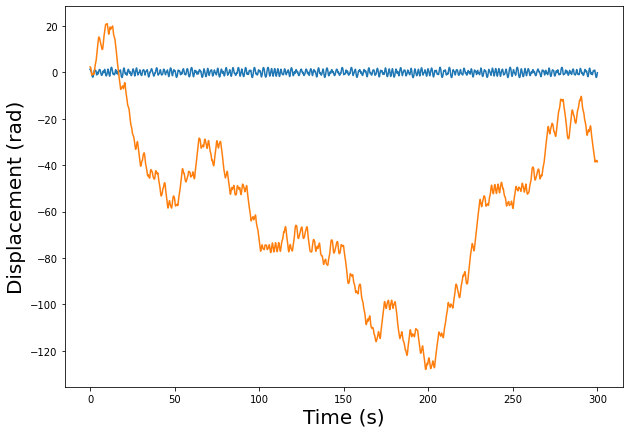

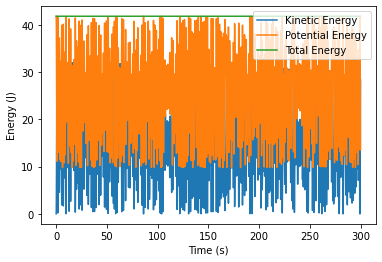

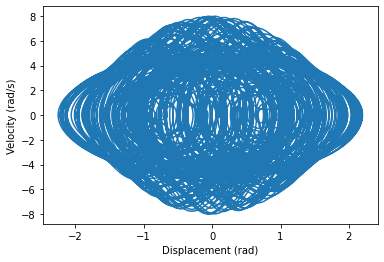

In [309]:

theta1, theta2 = y[:,0], y[:,2]
omega1, omega2 = y[:,1], y[:,3]

plt.figure(0, figsize=(10,7))
plt.plot(t, theta1)
plt.plot(t, theta2)
plt.xlabel('Time (s)', fontsize=20)
plt.ylabel('Displacement (rad)', fontsize=20)

plt.figure(1)
plt.plot(t, T, label='Kinetic Energy')
plt.plot(t, V, label='Potential Energy')
plt.plot(t, E, label='Total Energy')
plt.legend(loc='upper right')
plt.xlabel('Time (s)')
plt.ylabel('Energy (J)')

plt.figure(2)
plt.plot(theta1, omega1)
plt.xlabel('Displacement (rad)')
plt.ylabel('Velocity (rad/s)')

In [318]:
np.max(scaled_y, axis=0), np.min(scaled_y, axis=0)

(array([0.76425323, 0.23478635]), array([-0.77251389, -0.23719786]))

In [316]:
np.max(y, axis=0), np.min(y, axis=0)

(array([ 2.19933743,  7.98655603, 21.04419594, 11.19848423]),
 array([  -2.25140748,   -7.99376137, -128.10813393,  -11.31091172]))

In [328]:
'''
Data preprocessing for NN
'''
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data.dataloader as dataloader

device = torch.device("cuda:0")


sampling_step = 100    # sample a row for every the step.
sampling_ind = np.arange(0, t.shape[0]-1, sampling_step)
scaler = 1.0
scaled_y = np.array(y)
# scaled_y[:,1] = scaled_y[:,1]*scaler

input_output_y = np.concatenate((scaled_y[:-1], scaled_y[1:]), axis=1)    # [[input, output]]
X = torch.tensor(np.concatenate((input_output_y[sampling_ind], )), dtype=torch.float32, device=device)

num_samples = X.shape[0]
X_tr, X_val, X_te = X[:int(num_samples*0.6)], X[int(num_samples*0.6):int(num_samples*0.6)], X[int(num_samples*0.6):]

train_loader = dataloader.DataLoader(X_tr, batch_size=32, shuffle=True)
print("data size: {}/{}/{}".format(len(train_loader.dataset), len(X_val), len(X_te)))

data size: 18000/0/12000


In [329]:
scaled_y.shape

(3000001, 2)

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.net = nn.Sequential(nn.Linear(2,32),
                                 nn.ReLU(),
                                 nn.Linear(32,2))
        
    def forward(self, x):
        return self.net(x)


# lr = 0.00005
lr = 0.0001
model = Net().to(device)
total_params = sum(p.numel() for p in model.parameters())
print("total parameters: {}".format(total_params))

loss_fn = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=lr)
# optimizer = optim.Adadelta(model.parameters(), lr=0.05)

epochs = 20
log_interval = 200
input_dim = 4
# Training
for epoch in range(1, epochs+1):
    model.train()
    for batch_idx, data in enumerate(train_loader):
        data, target = data[:,:input_dim], data[:,input_dim:]    # check
        optimizer.zero_grad()
        output = model(data)
        _, _, curr_E = calc_E(data)
        _, _, pred_E = calc_E(output)
        _, _, target_E = calc_E(target)
                
#         loss = loss_fn(output, target)    # No rules

#         loss = (loss_fn(output, target) + loss_fn(pred_E, target_E)) + \
#                torch.mean(F.relu(pred_E - curr_E))
        alpha = 1.0
        loss = (1-alpha)*(loss_fn(output, target) + loss_fn(pred_E, target_E)) + \
               alpha*torch.mean(F.relu(pred_E - curr_E))
        
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

# Test
model.eval()
test_loss = 0
with torch.no_grad():
    target = X_te[:,2:]
    output = model(X_te[:,:2])
    test_loss = loss_fn(output, target).item()  # sum up batch loss

print('\nTest set: Average loss: {:.8f}\n'.format(test_loss))

In [ ]:
# Plotted bob circle radius
r = 0.05
# Plot a trail of the m2 bob's position for the last trail_secs seconds.
trail_secs = 1
# This corresponds to max_trail time points.
max_trail = int(trail_secs / dt)


def make_plot(i):
    # Plot and save an image of the double pendulum configuration for time
    # point i.
    # The pendulum rods.
    ax.plot([0, x1[i], x2[i]], [0, y1[i], y2[i]], lw=2, c='k')
    # Circles representing the anchor point of rod 1, and bobs 1 and 2.
    c0 = Circle((0, 0), r/2, fc='k', zorder=10)
    c1 = Circle((x1[i], y1[i]), r, fc='b', ec='b', zorder=10)
    c2 = Circle((x2[i], y2[i]), r, fc='r', ec='r', zorder=10)
    ax.add_patch(c0)
    ax.add_patch(c1)
    ax.add_patch(c2)

    # The trail will be divided into ns segments and plotted as a fading line.
    ns = 20
    s = max_trail // ns

    for j in range(ns):
        imin = i - (ns-j)*s
        if imin < 0:
            continue
        imax = imin + s + 1
        # The fading looks better if we square the fractional length along the
        # trail.
        alpha = (j/ns)**2
        ax.plot(x2[imin:imax], y2[imin:imax], c='r', solid_capstyle='butt',
                lw=2, alpha=alpha)

    # Centre the image on the fixed anchor point, and ensure the axes are equal
    ax.set_xlim(-L1-L2-r, L1+L2+r)
    ax.set_ylim(-L1-L2-r, L1+L2+r)
    ax.set_aspect('equal', adjustable='box')
    plt.axis('off')
    plt.savefig('frames/_img{:04d}.png'.format(i//di), dpi=72)
    plt.cla()


# Make an image every di time points, corresponding to a frame rate of fps
# frames per second.
# Frame rate, s-1
fps = 10
di = int(1/fps/dt)
fig = plt.figure(figsize=(8.3333, 6.25), dpi=72)
ax = fig.add_subplot(111)

for i in range(0, t.size, di):
    print(i // di, '/', t.size // di)
    make_plot(i)